In [1]:
!pip install neuralprophet[live]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.4/145.4 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: holidays
    Found existing installation: holidays 0.24
    Uninstalling holidays-0.24:
      Successfully uninstalled holidays-0.24
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.2.2
    Uninstalling pytorch-lightning-2.2.2:
      Successfully uninstalled pytorch-lightning-2.2.2


In [2]:
import matplotlib.pyplot as plt
from neuralprophet import NeuralProphet
import pandas as pd

import math
import seaborn as sns

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')


In [4]:
# Đọc và chuẩn bị dữ liệu
pjme = pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv',
                   index_col=[0],
                  parse_dates=[0])
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [5]:
pjme.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


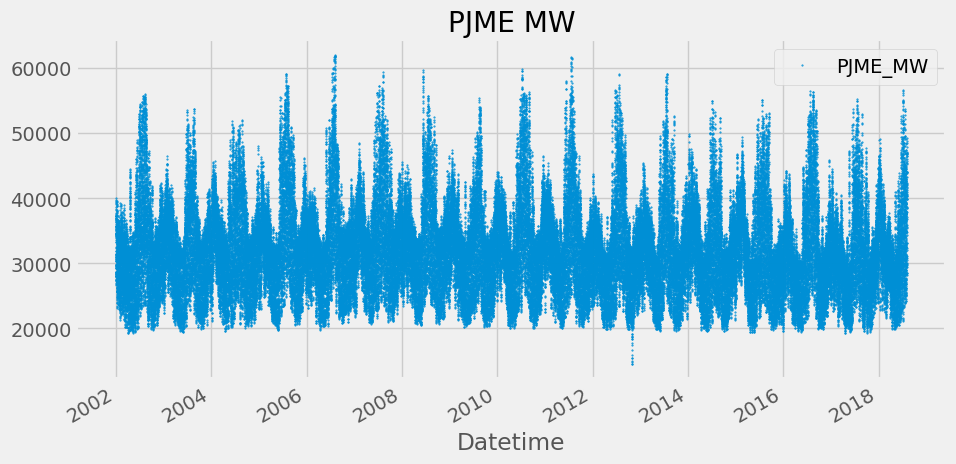

In [6]:
color_pal = sns.color_palette()
pjme.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='PJME MW')
plt.show()

In [7]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

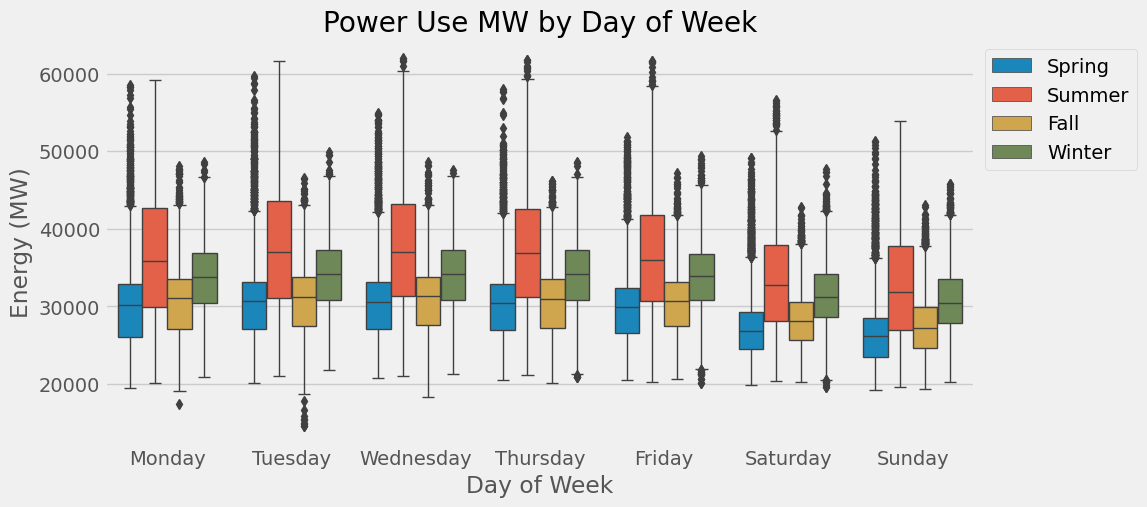

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In [9]:
split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

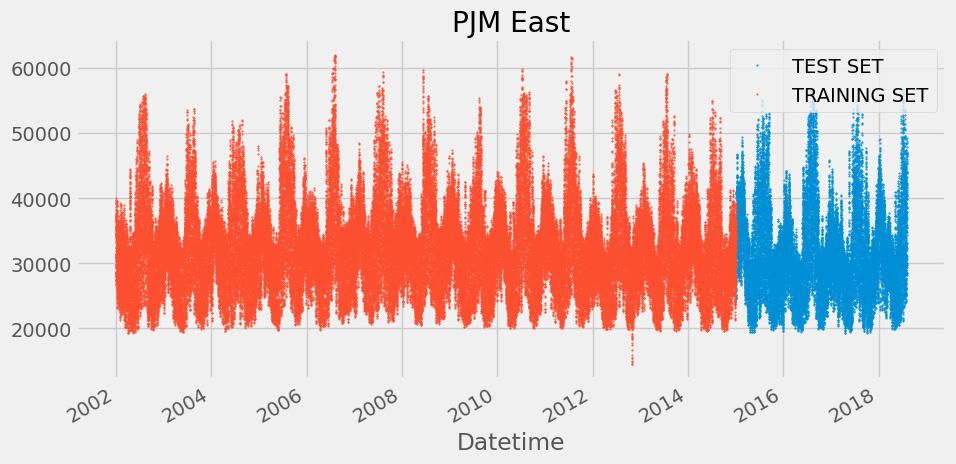

In [10]:


# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='PJM East', style='.', ms=1)
plt.show()

Preprocessing

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential 
from keras.layers import LSTM, Dense,Dropout

from tensorflow.keras.callbacks import EarlyStopping
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
pjme_train_scaled = scaler.fit_transform(pjme_train)
pjme_test_scaled = scaler.transform(pjme_test)

# Chuyển đổi dữ liệu thành định dạng tensor 3D
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)


TIME_STEPS = 24  
X_train, y_train = create_dataset(pjme_train_scaled, pjme_train_scaled[:, 0], TIME_STEPS)

X_test, y_test = create_dataset(pjme_test_scaled, pjme_test_scaled[:, 0], TIME_STEPS)



2024-06-11 20:17:35.176382: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 20:17:35.176485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 20:17:35.282253: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [12]:

# Xây dựng mô hình LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=200, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mse')

# monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
#         verbose=1, mode='auto', restore_best_weights=True)

# Huấn luyện mô hình
model_lstm.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.1)

# # Đánh giá mô hình trên tập kiểm tra
# model.evaluate(X_test, y_test)

# # Dự đoán trên tập kiểm tra
# y_pred = model.predict(X_test)


Epoch 1/50
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0055 - val_loss: 5.9761e-04
Epoch 2/50
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 7.4313e-04 - val_loss: 4.0493e-04
Epoch 3/50
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 5.2332e-04 - val_loss: 3.4262e-04
Epoch 4/50
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 4.5289e-04 - val_loss: 3.1745e-04
Epoch 5/50
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 3.8886e-04 - val_loss: 3.5108e-04
Epoch 6/50
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 3.5651e-04 - val_loss: 2.8419e-04
Epoch 7/50
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 3.2144e-04 - val_loss: 2.7860e-04
Epoch 8/50
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 3.0828e-04 - val_loss: 2.5648e-04
Epoch 9/50
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 2.9383e-04 - val_loss: 2.5155e-04
Epoch 10/50
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 2.8150e-04 - val_loss: 2.3400e-04
Epoch 11/50
1602/1602 ━━━━━━━━━━━━━━━━━━━

In [13]:
# Format data for prophet model using ds and y
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})
pjme_train_prophet = pjme_train_prophet.drop_duplicates(subset='ds')

In [14]:
# Đổi tên cột chứa thời điểm từ 'Datetime' thành 'ds'

pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})
pjme_test_prophet = pjme_test_prophet.drop_duplicates(subset='ds')

In [15]:
# 1. Huấn luyện mô hình NeuralProphet
model_neuralprophet = NeuralProphet()
model_neuralprophet.fit(pjme_train_prophet, freq='D')

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 95.81% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency h
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 256
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 30


Finding best initial lr:   0%|          | 0/276 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,9894.248047,12449.545898,0.165910,0.0,0
1,2888.089111,3839.324463,0.019751,0.0,1
2,2746.715332,3675.870117,0.018578,0.0,2
3,2733.727051,3658.215820,0.018511,0.0,3
4,2756.358643,3677.848145,0.018731,0.0,4
5,2784.005859,3710.894531,0.019044,0.0,5
6,2792.615723,3718.316650,0.019127,0.0,6
7,2827.070801,3752.140869,0.019501,0.0,7
8,2842.364990,3773.635010,0.019785,0.0,8
9,2821.494385,3752.062500,0.019485,0.0,9


In [16]:
y_pred_lstm = model_lstm.predict(X_test)
y_pred_prophet = model_neuralprophet.predict(pjme_test_prophet)

982/982 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 95.82% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency h
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 95.82% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency h


Predicting: 446it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [17]:
# Format data for prophet model using ds and y
pjme_train_prophet = (
    pjme_train.reset_index()
    .rename(columns={"Datetime": "ds", "PJME_MW": "y"})
    .drop_duplicates(subset="ds")
)

pjme_test_prophet = (
    pjme_test.reset_index()
    .rename(columns={"Datetime": "ds", "PJME_MW": "y"})
    .drop_duplicates(subset="ds")
)


In [18]:
model_neuralprophet = NeuralProphet()
model_neuralprophet.fit(pjme_train_prophet, freq="D")


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 95.81% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency h
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 256
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 30


Finding best initial lr:   0%|          | 0/276 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,13160.940430,16551.953125,0.229084,0.0,0
1,3154.419678,4162.540039,0.022407,0.0,1
2,2784.032227,3716.956055,0.018919,0.0,2
3,2761.616699,3691.453369,0.018821,0.0,3
4,2781.702881,3715.500000,0.019112,0.0,4
5,2792.232666,3727.297607,0.019231,0.0,5
6,2823.741699,3758.960449,0.019558,0.0,6
7,2857.040283,3792.351562,0.019929,0.0,7
8,2856.434814,3794.447754,0.019949,0.0,8
9,2873.428467,3810.839111,0.020182,0.0,9


In [19]:
start_date_lstm = pjme_test_prophet["ds"].iloc[0]

In [20]:
pjme_test_lstm = pjme_test[pjme_test.index >= start_date_lstm].copy()
pjme_test_lstm_scaled = scaler.transform(pjme_test_lstm)
X_test_lstm, _ = create_dataset(
    pjme_test_lstm_scaled, pjme_test_lstm_scaled[:, 0], TIME_STEPS
)

# Xây dựng mô hình LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=200, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer="adam", loss="mse")

In [21]:
# Huấn luyện mô hình
model_lstm.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1)

Epoch 1/20
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0061 - val_loss: 6.3232e-04
Epoch 2/20
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 7.5163e-04 - val_loss: 3.8890e-04
Epoch 3/20
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 5.3671e-04 - val_loss: 3.5253e-04
Epoch 4/20
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 4.6791e-04 - val_loss: 3.3363e-04
Epoch 5/20
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 4.0668e-04 - val_loss: 3.0594e-04
Epoch 6/20
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 3.6241e-04 - val_loss: 2.8400e-04
Epoch 7/20
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 3.2996e-04 - val_loss: 2.8099e-04
Epoch 8/20
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 3.1620e-04 - val_loss: 2.6558e-04
Epoch 9/20
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 2.9295e-04 - val_loss: 2.5546e-04
Epoch 10/20
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 2.9157e-04 - val_loss: 2.5822e-04
Epoch 11/20
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 

In [22]:
# Make predictions
y_pred_lstm = model_lstm.predict(X_test_lstm)
y_pred_lstm = y_pred_lstm.reshape(-1, 1)
y_pred_prophet = model_neuralprophet.predict(pjme_test_prophet)
y_pred_prophet = y_pred_prophet["yhat1"].values.reshape(-1, 1)

709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 95.82% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency h
INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 95.82% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency h


Predicting: 446it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [23]:
# *** Trim NeuralProphet to match LSTM length ***
y_pred_prophet = y_pred_prophet[: len(y_pred_lstm)]

In [24]:
# --- Combining outputs for ANN ---
X_ann = np.concatenate((y_pred_lstm, y_pred_prophet), axis=1)
scaler_ann = MinMaxScaler()
X_ann_scaled = scaler_ann.fit_transform(X_ann)

In [25]:
y_test_ann = pjme_test_lstm["PJME_MW"].values[TIME_STEPS: len(y_pred_lstm) + TIME_STEPS]

In [26]:
# --- Create and train the ANN ---
model_ann = Sequential()
model_ann.add(
    Dense(units=100, activation="relu", input_shape=(X_ann_scaled.shape[1],))
)
model_ann.add(Dense(units=50, activation="relu"))
model_ann.add(Dense(units=1))
model_ann.compile(optimizer="adam", loss="mse")

In [27]:
model_ann.fit(
    X_ann_scaled, y_test_ann, epochs=50, batch_size=32, validation_split=0.1
)

Epoch 1/50
109/638 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 992483264.0000

I0000 00:00:1718137760.114865      90 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


638/638 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 989095488.0000 - val_loss: 773060352.0000
Epoch 2/50
638/638 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 549127808.0000 - val_loss: 57640380.0000
Epoch 3/50
638/638 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 35139152.0000 - val_loss: 17115104.0000
Epoch 4/50
638/638 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8763624.0000 - val_loss: 16744694.0000
Epoch 5/50
638/638 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8035571.5000 - val_loss: 15439428.0000
Epoch 6/50
638/638 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7513703.0000 - val_loss: 13953067.0000
Epoch 7/50
638/638 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6548962.5000 - val_loss: 12372239.0000
Epoch 8/50
638/638 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5695120.5000 - val_loss: 10044807.0000
Epoch 9/50
638/638 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4653262.0000 - val_loss: 8019337.5000
Epoch 10/50
638/638 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3575865.7500 - val_loss: 6136206.0000
Epoch 11/50
638/

In [28]:
# --- Evaluate and Predict ---
model_ann.evaluate(X_ann_scaled, y_test_ann)
y_pred_ann = model_ann.predict(X_ann_scaled)



709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 455000.8438
709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


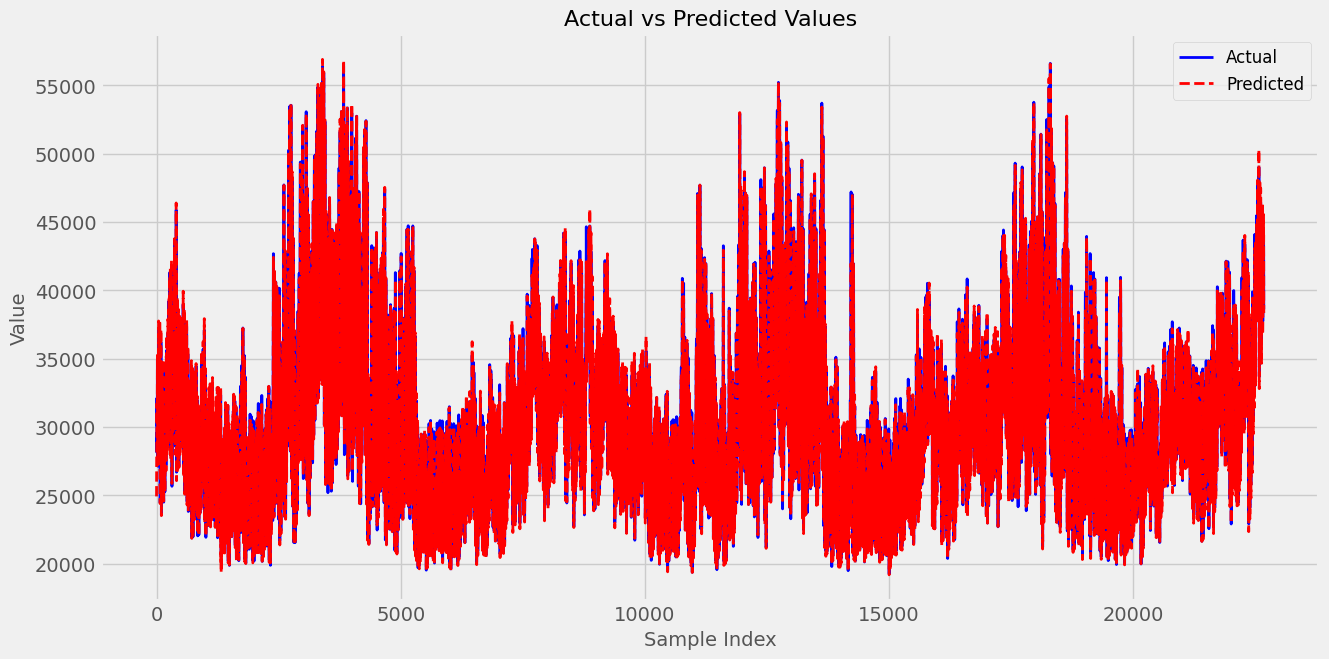

In [29]:
# Vẽ biểu đồ
plt.figure(figsize=(14, 7))  # Điều chỉnh kích thước biểu đồ
plt.plot(y_test_ann, label="Actual", color='blue', linestyle='-', linewidth=2)
plt.plot(y_pred_ann, label="Predicted", color='red', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Values', fontsize=16)  # Thêm tiêu đề
plt.xlabel('Sample Index', fontsize=14)  # Thêm nhãn trục x
plt.ylabel('Value', fontsize=14)  # Thêm nhãn trục y
plt.legend(fontsize=12)  # Hiển thị chú giải với kích thước phông chữ lớn hơn
plt.grid(True)  # Thêm đường lưới
plt.show()

In [30]:
# --- Calculate Evaluation Metrics ---
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    nrmse = rmse / np.std(y_true) 
    return rmse, mae, mape, nrmse

rmse, mae, mape, nrmse = calculate_metrics(y_test_ann, y_pred_ann)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"NRMSE: {nrmse:.2f}")

RMSE: 721.76
MAE: 418.48
MAPE: 22.67%
NRMSE: 0.11
